In [1]:
import matlab.engine
from matpower import path_matpower

import pandapower as pp
import geopandas as gpd
import math
import json
import pickle
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from pandapower import control
from pandapower.control import ConstControl
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matlab
np.random.seed(42)

In [2]:
# LV_list=   ['214-1_1_5', '216-2_1_3', '214-1_2_2', '216-2_0_2', '216-1_1_3',
#            '216-1_2_4', '216-3_0_5', '39-1_0_4', '225-2_0_3', '225-4_0_3',
#            '225-1_0_6', '225-2_1_5', '225-3_0_6', '298-1_1_4', '298-4_0_2',
#            '225-5_0_5', '230-106_0_2', '298-2_0_5', '298-7_1_3', '298-7_0_3',
#            '298-5_0_5', '298-6_0_2','298-3_0_3', '298-8_0_7', '227-12_0_5',
#            '227-7_0_5', '227-10_1_3', '227-11_0_4', '230-150_0_2',
#            '227-9_0_5', '230-202_0_2', '230-180_0_4', '230-197_0_5',
#            '230-200_0_4', '230-202_1_3', '230-201_0_6', '230-211_0_2',
#            '230-212_0_3', '230-212_1_3', '230-108_0_6', '227-13_0_3',
#            '227-14_0_4', '227-8_0_10', '227-13_1_3', '227-1_0_5', '227-6_1_4',
#            '227-3_0_5', '298-9_0_5', '298-6_1_4', '298-4_1_5']
m = matlab.engine.start_matlab()
case_id='225-1_0_6'
zone='Midlands-Periurban'
MV_feeder = False
grid = "369_0"
folder ='225-1_0_6'#'298-6_0_2'#'298-4_1_5'#'216-1_1_3' 
scenario_year = 2050
weekday = "Friday"
day_start_ts = pd.to_datetime(f"{scenario_year}-01-07 00:00:00")
day_start = day_start_ts.day
day_end_ts = pd.to_datetime(f"{scenario_year}-01-08 00:00:00")
# month = day_start_ts.month
monitor_hr =int((day_end_ts - day_start_ts).total_seconds() / 3600)
path_controlled = f"{grid}/{scenario_year}_{weekday}_01_07_controlled"
path_uncontrolled = f"{grid}/{scenario_year}_{weekday}_01_07_uncontrolled"
grid_nodes, grid_edges = gpd.read_file(f"/Users/huiwen/Desktop/OneDrive/ETHZ/Thesis/LV/{zone}/{case_id}_nodes"), gpd.read_file(f"/Users/huiwen/Desktop/OneDrive/ETHZ/Thesis/LV/{zone}/{case_id}_edges")

In [3]:
def get_lv_consumer_bus(net):
    base_load=net.load[net.load.category=='base']
    lv_consumer_bus_idx= net.bus[net.bus.index.isin(base_load.bus) & (net.bus.vn_kv==0.4)].index
    mv_consumer_bus_idx=net.bus[net.bus.index.isin(base_load.bus) & (net.bus.vn_kv==20)].index
    lv_consumer_bus=net.bus_geodata.loc[lv_consumer_bus_idx]
    lv_consumer_bus_gdf = gpd.GeoDataFrame(lv_consumer_bus,
                                            geometry=gpd.points_from_xy(x=lv_consumer_bus.x, y=lv_consumer_bus.y),
                                            crs="epsg:2056")
    return lv_consumer_bus_gdf

def load_real_base_profile():
    # Winit Load Profile with base load of year 2024
    winti = pd.read_csv(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/Timeseries/winterthur_load.csv")
    winti.zeitpunkt = pd.to_datetime(pd.to_datetime(winti.zeitpunkt).dt.strftime('%Y-%m-%d %H:%M:%S'))
    winti['datehour'] = winti.zeitpunkt.dt.strftime('%Y-%m-%d %H:00:00')
    winti_hourly = winti.groupby(['datehour']).bruttolastgang_kwh.sum()  # kWh
    return winti_hourly


def create_normalized_base_profile(day_start_ts):
    winti_profile = pd.DataFrame()
    winti_hourly = load_real_base_profile()
    winti_day_start = day_start_ts.replace(year=2023)
    selection_start_date = winti_day_start - pd.DateOffset(days=10)
    selection_end_date = winti_day_start + pd.DateOffset(days=10)
    for selected_date in pd.date_range(start=selection_start_date, end=selection_end_date):
        day_base_start = pd.to_datetime(pd.to_datetime(selected_date).strftime('%Y-%m-%d %H:%M:%S'))
        day_base_end = day_base_start + timedelta(hours=23)
        day_base = winti_hourly.loc[str(day_base_start):str(day_base_end)]
        day_base_norm = pd.DataFrame((day_base / day_base.max())).rename(
            columns={'bruttolastgang_kwh': 'norm'}).reset_index(drop=True)
        winti_profile = pd.concat([winti_profile, day_base_norm], ignore_index=True, axis=1)
    return winti_profile

def read_LV_zone_dict():
    # Data Processing
    LV_zone_dict = {}
    LV_path = ("LV/")

    with open("/Users/huiwen/Desktop/OneDrive/ETHZ/Thesis/file_folder_lv.json", 'r') as file:
        LV_zone_dict = json.load(file)
    return LV_zone_dict


def read_MV_nodes_all():
    MV_nodes_all = gpd.read_file('/Users/huiwen/Desktop/OneDrive/ETHZ/Thesis/MV_nodes_all.geojson')
    # Convert dtype
    MV_nodes_all['osmid'] = MV_nodes_all['osmid'].astype(int)
    # MV_nodes_all['consumers'] = MV_nodes_all['consumers'].astype(bool)
    MV_nodes_all = MV_nodes_all.to_crs(epsg=2056)
    MV_nodes_all['x'], MV_nodes_all['y'] = MV_nodes_all.geometry.x, MV_nodes_all.geometry.y
    return MV_nodes_all


def read_MV_edges_all():
    MV_edges_all = gpd.read_file('/Users/huiwen/Desktop/OneDrive/ETHZ/Thesis/MV_edges_all.geojson')
    return MV_edges_all

def get_Q(P, pf):
    """
    Calculate the reactive power (Q) given the real power (P) and the power factor (PF).
    Parameters:
    P: Real power in mW.
    pf: Power factor, ranging from -1(leading) to 1(lagging).

    Returns:
    Q: Reactive power (Q) in mvar.
    """
    S = P / pf
    Q = math.sqrt(S ** 2 - P ** 2)
    if pf < 0:
        Q = -Q
    return Q


def build_LV_net(case_id, zone=None, net=None, resp_MV=None):
    if zone is None:
        LV_zone_dict = read_LV_zone_dict()
        zone = LV_zone_dict[case_id]

    # Flag: Ture -> expand LV for selected MV, False->Create only LV network
    expand = False if net is None else True

    LV_pf = 0.97
    
    # Line types
    if zone.endswith('Urban'):
        LV_zone_line = {"line_type": "NAYY 4x240 SE", "line_type_in_lib": False, "r_ohm_per_km": 0.125,
                        "x_ohm_per_km": 0.08, "c_nf_per_km": 260, "g_us_per_km": 81.995568, "max_i_ka": 0.364, "type": "cs"} # c_nf_per_km not correct
    else:
        LV_zone_line = {"line_type": "NAYY 4x150 SE", "line_type_in_lib": True,"r_ohm_per_km": 0.208,
                        "x_ohm_per_km": 0.08, "c_nf_per_km": 261, "g_us_per_km": 81.995568, "max_i_ka": 0.27, "type": "cs"}

    # Trafo types
    if zone.endswith('rban'):
        LV_zone_trafo = {"trafo_type": "0.63 MVA 20/0.4 kV"}
    else:
        LV_zone_trafo = {"trafo_type": "0.25 MVA 20/0.4 kV"}

    # Read LV Grid Data
    grid_nodes, grid_edges = gpd.read_file(f"/Users/huiwen/Desktop/OneDrive/ETHZ/Thesis/LV/{zone}/{case_id}_nodes"), gpd.read_file(
        f"/Users/huiwen/Desktop/OneDrive/ETHZ/Thesis/LV/{zone}/{case_id}_edges")
    grid_nodes=grid_nodes.to_crs(epsg=2056)
    # Convert dtype
    grid_nodes['osmid'] = grid_nodes['osmid'].astype(int)
    # grid_nodes['consumers'] = grid_nodes['consumers'].astype(bool)

    # # Find respective MV bus connected to the LV grid
    MV_nodes_all = read_MV_nodes_all()
    resp_MV = MV_nodes_all[MV_nodes_all['lv_grid'] == case_id]

    if not expand:
        # Create LV Grid
        grid = pp.create_empty_network()
        trafo_tap = 0

        # resp_MV = MV_nodes_all[MV_nodes_all['lv_grid'] == case_id]
    else:
        grid = net
        trafo_tap = -2
    for index, node in grid_nodes.iterrows():
        # Add nodes to the grid
        pp.create_bus(grid, 0.4, name=case_id + '_node_' + str(node['osmid']),geodata=(node['x'], node['y']), type='n', zone=zone, in_service=True,max_vm_pu=1.03, min_vm_pu=0.97)

        # Index of the bus just created
        mask_this_LV_bus = (grid.bus.name == case_id + '_node_' + str(node['osmid']))
        this_LV_bus_id = grid.bus.loc[mask_this_LV_bus].index[0]

        # Add load to the grid
        if node['consumers']=='True' and node['el_dmd']!=0:
            pp.create_load(grid, bus=this_LV_bus_id, p_mw=node['el_dmd'], q_mvar=get_Q(node['el_dmd'], LV_pf),name=f'base_load_{case_id}_{node.osmid}',controllable=False,category='base',el_dmd=node['el_dmd'])

        # Add tansformer to the grid
        if node['source']:
            pp.create.create_ext_grid(grid,bus=this_LV_bus_id,vm_pu=1,va_degree=0.0,in_service=True,controllable=True)
            # resp_MV_case_id, resp_MV_osmid = str(resp_MV['MV_case_id'].iloc[0]), str(resp_MV['osmid'].iloc[0])

            # if not expand:
                # # Create respective MV bus
                # pp.create_bus(grid, vn_kv=20, name=f"MV_case_id_{resp_MV_case_id}_osmid_{resp_MV_osmid}",
                #               geodata=(resp_MV['x'].iloc[0], resp_MV['y'].iloc[0]), type='b', zone=zone,
                #               in_service=True, max_vm_pu=1.01, min_vm_pu=0.99)
                # # Mask trafo HV/LV bus
                # mask_trafo_hv_bus = (grid.bus.name == f"MV_case_id_{resp_MV_case_id}_osmid_{resp_MV_osmid}")
                # pp.create.create_ext_grid(grid,bus=this_LV_bus_id,vm_pu=1,va_degree=0.0,in_service=True,controllable=True)
            # else:
            #     mask_trafo_hv_bus = (grid.bus.name == f"{resp_MV_case_id}_node_{resp_MV_osmid}")

            # trafo_hv_bus_id = grid.bus.loc[mask_trafo_hv_bus].index[0]
            # pp.create_transformer(grid, name=f"trafo_on_{case_id}_node_{node['osmid']}", hv_bus=trafo_hv_bus_id,
            #                       lv_bus=this_LV_bus_id, std_type=LV_zone_trafo['trafo_type'],tap_pos=trafo_tap)

    for index, edge in grid_edges.iterrows():
        # Mask the corresponding from/to bus for this edge
        mask_from_bus, mask_to_bus = (grid.bus.name == case_id + '_node_' + edge['u']), (
                grid.bus.name == case_id + '_node_' + edge['v'])
        from_bus_index, to_bus_index = grid.bus.loc[mask_from_bus].index[0], grid.bus.loc[mask_to_bus].index[0]

        # Add line to the grid
        pp.create_line_from_parameters(grid, name=f"{case_id}_{edge['u']}_{edge['v']}",
                                           from_bus=from_bus_index, to_bus=to_bus_index, length_km=edge['length'],
                                           r_ohm_per_km=edge['r']/edge['length']*edge['line_type'],
                                           x_ohm_per_km=edge['x']/edge['length']*edge['line_type'],
                                           c_nf_per_km=edge['b']*1000000000/(edge['length']*2*np.pi*50)/edge['line_type'], max_i_ka=edge['s_nom']/(np.sqrt(3)*0.4)/edge['line_type'],
                                           type=LV_zone_line['type'], in_service=True,max_loading_percent=70,parallel=edge['line_type'])
    print(f"Finish building LV {case_id}")
    return grid


def get_MV_line(line_type, OHL):
    if OHL:
        if line_type == 1:
            MV_zone_line = {"line_type": "48-AL1/8-ST1A 20.0", "line_type_in_lib": True}
        elif line_type == 2:
            MV_zone_line = {"line_type": "94-AL1/15-ST1A 20.0", "line_type_in_lib": True}
        elif line_type == 3:
            MV_zone_line = {"line_type": "122-AL1/20-ST1A 20.0", "line_type_in_lib": True}
        elif line_type == 4:
            MV_zone_line = {"line_type": "243-AL1/39-ST1A 20.0", "line_type_in_lib": True}
        elif line_type == 5:
            MV_zone_line = {"line_type": "2x122-AL1/20-ST1A 20.0", "line_type_in_lib": False,
                            "r_ohm_per_km": 0.2376 / 2, "x_ohm_per_km": 0.344 / 2, "c_nf_per_km": 10.3 * 2,
                            "g_us_per_km": 6.4716, "max_i_ka": 0.41 * 2, "type": "ol"}
        elif line_type == 6:
            MV_zone_line = {"line_type": "2x243-AL1/39-ST1A 20.0", "line_type_in_lib": False,
                            "r_ohm_per_km": 0.1188 / 2, "x_ohm_per_km": 0.32 / 2, "c_nf_per_km": 11 * 2,
                            "g_us_per_km": 6.911504, "max_i_ka": 0.645 * 2, "type": "ol"}
        else:
            print("Error: MV line type not defined!")
    else:
        if line_type == 1:
            MV_zone_line = {"line_type": "NA2XS2Y 1x70 RM/25 12/20 kV", "line_type_in_lib": True}
        elif line_type == 2:
            MV_zone_line = {"line_type": "NA2XS2Y 1x185 RM/25 12/20 kV", "line_type_in_lib": True}
        elif line_type == 3:
            MV_zone_line = {"line_type": "NA2XS2Y 1x240 RM/25 12/20 kV", "line_type_in_lib": True}
        elif line_type == 4:
            MV_zone_line = {"line_type": "NA2XS2Y 2x150 RM/25 12/20 kV", "line_type_in_lib": False,
                            "r_ohm_per_km": 0.206 / 2, "x_ohm_per_km": 0.116 / 2, "c_nf_per_km": 250 * 2,
                            "g_us_per_km": 157.0796, "max_i_ka": 0.319 * 2, "type": "cs"}
        elif line_type == 5:
            MV_zone_line = {"line_type": "2x122-AL1/20-ST1A 20.0", "line_type_in_lib": False, "r_ohm_per_km": 0.122 / 2,
                            "x_ohm_per_km": 0.112 / 2, "c_nf_per_km": 304 * 2, "g_us_per_km": 191.008833, "max_i_ka": 0.421 * 2,
                            "type": "cs"}
        elif line_type == 6:
            MV_zone_line = {"line_type": "2x243-AL1/39-ST1A 20.0", "line_type_in_lib": False, "r_ohm_per_km": 0.206 / 4,
                            "x_ohm_per_km": 0.116 / 4, "c_nf_per_km": 250 * 4, "g_us_per_km": 314.159265, "max_i_ka": 0.319 * 4,
                            "type": "cs"}
        else:
            print("Error: MV line type not defined!")
    return MV_zone_line


def build_MV_LV_net(MV_case_id):

    LV_zone_dict = read_LV_zone_dict()
    MV_nodes_all = read_MV_nodes_all()
    MV_pf = 0.9
    MV_zone_trafo = {"trafo_type": "25 MVA 110/20 kV"}
    # Read MV Grid Data
    MV_nodes, MV_edges = gpd.read_file(f"/Users/huiwen/Desktop/OneDrive/ETHZ/Thesis/MV/{MV_case_id}_nodes"), gpd.read_file(
        f"/Users/huiwen/Desktop/OneDrive/ETHZ/Thesis/MV/{MV_case_id}_edges")

    # Convert dtype
    MV_nodes['osmid'] = MV_nodes['osmid'].astype(int)
    MV_nodes = MV_nodes.to_crs(epsg=2056)
    # MV_nodes['consumers'] = MV_nodes['consumers'].astype(bool)

    # Create MV Grid
    net = pp.create_empty_network()

    for index, node in MV_nodes.iterrows():
        # Add buses
        pp.create_bus(net, 20, name=MV_case_id + '_node_' + str(node['osmid']), geodata=(node['x'], node['y']),
                      type='n', in_service=True,max_vm_pu=1.02,min_vm_pu=0.98)

        mask_this_MV_bus = (net.bus.name == MV_case_id + '_node_' + str(node['osmid']))
        this_MV_bus_id = net.bus.loc[mask_this_MV_bus].index[0]

        # Add transformer to the bus
        if node['source']:
            pp.create.create_ext_grid(net, bus=this_MV_bus_id, vm_pu=1, va_degree=0.0, in_service=True,controllable=True)
            
            # Connect HV/MV transforemr and HV bus
            pp.create_bus(net, 110, name=MV_case_id + '_HV_bus', geodata=(node['x'], node['y']), type='b',
                          in_service=True)
            mask_HV_bus = (net.bus.name == MV_case_id + '_HV_bus')
            HV_bus_id = net.bus.loc[mask_HV_bus].index[0]
            pp.create_transformer(net, name=f"trafo_on_{MV_case_id}_node_{node['osmid']}", hv_bus=HV_bus_id,
                                  lv_bus=this_MV_bus_id, std_type=MV_zone_trafo['trafo_type'],tap_pos=0)

        # Add load to the bus
        # Consumer not connected with LV
        if (node['consumers']=='True') and (node['lv_grid'] == '-1'):
            pp.create_load(net, bus=this_MV_bus_id, p_mw=node['el_dmd'], q_mvar=get_Q(node['el_dmd'], MV_pf),name=f"base_load_{MV_case_id}_{node.osmid}",controllable=False,category='base',el_dmd=node['el_dmd'])
        # Consumer connected with LV
        if (node['consumers']=='True') and (node['lv_grid'] != '-1'):
            LV_case_id = node['lv_grid']
            LV_zone = LV_zone_dict[node['lv_grid']]
            resp_MV = MV_nodes_all[MV_nodes_all['lv_grid'] == LV_case_id]
            net = build_LV_net(LV_case_id, LV_zone, net,resp_MV)

    for index, edge in MV_edges.iterrows():
        MV_zone_line = get_MV_line(edge['line_type'], edge['OHL'])
        # Mask the corresponding from/to bus for this edge
        mask_from_bus, mask_to_bus = (net.bus.name == MV_case_id + '_node_' + edge['u']), (
                net.bus.name == MV_case_id + '_node_' + edge['v'])
        from_bus_index, to_bus_index = net.bus.loc[mask_from_bus].index[0], net.bus.loc[mask_to_bus].index[0]

        # Add line to the grid
        pp.create_line_from_parameters(net, name=f"{MV_case_id}_{edge['u']}_{edge['v']}",
                                        from_bus=from_bus_index, to_bus=to_bus_index, length_km=edge['length'],
                                        r_ohm_per_km=edge['r']/edge['length'],
                                        x_ohm_per_km=edge['x']/edge['length'],
                                        c_nf_per_km=edge['b']*1000000000/(edge['length']*2*np.pi*50), max_i_ka=edge['s_nom']/(20*np.sqrt(3)),
                                        type=MV_zone_line['line_type'], in_service=True,max_loading_percent=70)


    print(f"Finish building MV {MV_case_id}")
    return net

# Base Load
def prepare_base_profile(net,day_start_ts):
    MV_pf = 0.9
    LV_pf = 0.97
    base_load = net.load.loc[net.load.category=='base']
    base_load_profile=pd.DataFrame(index=base_load.index,columns=['p_mw','q_mvar'])

    winti_profile = create_normalized_base_profile(day_start_ts)

    for idx, base in base_load.iterrows():
        v_lvl = net.bus.loc[net.load.loc[idx].bus].vn_kv
        if v_lvl == 0.4:
            pf = LV_pf
        else:
            pf = MV_pf
        el_dmd = net.load.loc[idx].el_dmd
        rand_norm_profile = winti_profile[np.random.choice(winti_profile.columns)].to_list()
        base_load_profile.at[idx, 'p_mw'] = [el_dmd * p for p in rand_norm_profile]
        base_load_profile.at[idx, 'q_mvar'] = [el_dmd * p * np.tan(np.arccos(pf)) for p in rand_norm_profile]
    return base_load_profile



# EV
def load_emob(path, grid, day_start_ts, monitor_hr, scenario_year):
    with open(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/mobility/{path}/grid_{grid}_matched_{day_start_ts}_{monitor_hr}_{scenario_year}.pkl",
            "rb") as emob:
        emob = pickle.load(emob)
    emob_geometry = [Point(xy) for xy in zip(emob.end_x, emob.end_y)]
    emob_gdf = gpd.GeoDataFrame(emob, geometry=emob_geometry, crs='epsg:2056')
    return emob_gdf

def prepare_ev_profile(net,path,grid,day_start_ts,monitor_hr,scenario_year):
    LV_pf = 0.97
    MV_pf = 0.9
    emob_gdf = load_emob(path, grid, day_start_ts, monitor_hr, scenario_year)
    lv_consumer_bus_gdf = get_lv_consumer_bus(net)
    # Spatial Join Nearest lv_consumer_bus_gdf to the EV parking location
    emob_assigned = gpd.sjoin_nearest(emob_gdf, lv_consumer_bus_gdf, how='left', max_distance=20,
                                        distance_col="distance")  # Assign emob profile only to LV nodes
    emob_assigned = emob_assigned.loc[~pd.isnull(emob_assigned.index_right)]  # filter for successfully mapped EVs
    # map bus geometry
    emob_assigned.rename(columns={"index_right": "Bus"}, inplace=True)
    emob_assigned['bus_geometry'] = emob_assigned['Bus'].map(lv_consumer_bus_gdf['geometry'])


    ev_load = emob_assigned.copy().drop(columns=['geometry', 'bus_geometry'], axis=1)
    # Drop Duplicated Assigned
    duplicated_indices = ev_load.index.duplicated(keep='first')
    ev_unique = ev_load[~duplicated_indices].copy()
    ev_unique['parking_cnt'] = ev_unique.sort_values(by='dep_time').groupby('person').cumcount()
    #Avoid too many cars on 1 node
    ev_unique['node_ev_cnt'] = ev_unique.groupby('Bus')['distance'].rank(method='first',ascending=True)
    # ev_unique = ev_unique.loc[ev_unique.node_ev_cnt<=50]
    ev_unique['optimized_power_list'] = ev_unique['optimized_power_list'].apply(lambda row:[power/1e3 for power in row])
    ev_unique['index']=0
    for iter, ev in ev_unique.iterrows():
        pp.create_storage(
            net,
            bus=int(ev.Bus),
            name=f"ev_{ev.person}_{iter}_{int(ev.Bus)}_{ev.shifted_st_chg_time.hour}",
            p_mw=ev['chg rate']/1000,
            q_mvar=0,
            soc_percent=ev.update_SoE_bc/ev.B*100 if ev.parking_cnt==0 else 0, 
            max_e_mwh=ev.B/1000,
            min_e_mwh=0.005,
            type='ev',
            max_p_mw=ev['chg rate']/1000,
            min_p_mw=-ev['chg rate']/1000,
            max_q_mvar=0,
            min_q_mvar=0,
            controllable=True,
            person=ev.person,
            chg_rate=ev['chg rate']/1000,
            arr_time_idx=ev.arr_time_idx,
            park_end_time_idx=ev.park_end_time_idx,
            SoC_change=ev.SoE_change/ev.B*100,
            next_SoC_change=ev.next_SoE_change/ev.B*100,
            next_trip_e = ev.next_trip_e/1000
            )
        mask_this_ev = net.storage.name==f"ev_{ev.person}_{iter}_{int(ev.Bus)}_{ev.shifted_st_chg_time.hour}"
        this_ev_storage_idx = net.storage.loc[mask_this_ev].index
        pp.create_poly_cost(net, this_ev_storage_idx, "storage", cp1_eur_per_mw=-10, cp0_eur=0, cq1_eur_per_mvar=0, cq0_eur=0, cp2_eur_per_mw2=0, cq2_eur_per_mvar2=0)
        ev_unique.loc[iter,'index'] = this_ev_storage_idx
    ev_unique.set_index('index',inplace=True)  
    print("EV added")
    return ev_unique


# HP
def load_hp_profile(day_start_ts):
    hp_install = pd.read_json(f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/Load_demand/Heatpump/369_0_heatpump_demand_v2.json")  # power in kW
    doy = day_start_ts.day_of_year
    def get_day_hp_profile(yearly, doy):
        return yearly[doy]
    hp_install['p'] = hp_install['p'].apply(get_day_hp_profile, doy=doy)
    hp_install['p'] = hp_install['p'].apply(lambda row:[power/1e6 for power in row]) # convert from W to MW
    hp_install['q'] = hp_install['p'].apply(lambda row:[np.tan(np.arccos(0.97)) *power for power in row])
    hp_install_gdf = gpd.GeoDataFrame(hp_install, geometry=gpd.points_from_xy(x=hp_install.GKODE, y=hp_install.GKODN),crs="epsg:2056")
    return hp_install_gdf

def prepare_hp_profile(net,day_start_ts):
    hp_gdf=load_hp_profile(day_start_ts)
    lv_consumer_bus_gdf = get_lv_consumer_bus(net)
    hp_assigned = gpd.sjoin_nearest(hp_gdf, lv_consumer_bus_gdf, how='left', max_distance=20, distance_col="distance") # Find nearest bus for heatpump

    hp_assigned = hp_assigned.loc[~pd.isnull(hp_assigned.index_right)] # Filter for succesfully mapped HP
    hp_assigned.rename(columns={"index_right": "Bus"}, inplace=True)
    hp_assigned['bus_geometry'] = hp_assigned['Bus'].map(lv_consumer_bus_gdf['geometry'])
    hp_load = hp_assigned.copy().drop(columns=['geometry', 'bus_geometry'], axis=1)
    duplicated_EGID = hp_load.EGID.duplicated(keep='first')
    hp_unique = hp_load[~duplicated_EGID].copy()
    hp_unique['index']=0
    # hp_unique.set_index('EGID', inplace=True)
    for iter, hp in hp_unique.iterrows():
        pp.create_load(net, bus=hp['Bus'], p_mw=hp['PRT']/1e6, q_mvar=get_Q(hp['PRT']/1e6,0.97),name=f"hp_load_{int(hp.Bus)}_{hp.EGID}",controllable=False,category='hp',el_dmd=hp.PRT/1e6)
        mask_this_hp = net.load.name==f"hp_load_{int(hp.Bus)}_{hp.EGID}"
        this_hp_load_idx = net.load.loc[mask_this_hp].index
        hp_unique.loc[iter,'index'] = this_hp_load_idx
    hp_unique.set_index('index',inplace=True) 
    print("HP added")       
    return hp_unique


# PV
def load_pv_profile(day_start_ts):
    pv_install = pd.read_json(
        f"/Users/huiwen/Library/Mobile Documents/com~apple~CloudDocs/Thesis/Load_demand/PV/369_0_PV_powerlist_max_P_v3.json")  # power in kW
    doy = day_start_ts.day_of_year

    def get_day_pv_profile(yearly, doy):
        return yearly[doy]

    pv_install['pv_P_daily'] = pv_install['pv_P_daily'].apply(get_day_pv_profile, doy=doy)
    pv_install['pv_P_daily'] = pv_install['pv_P_daily'].apply(lambda row:[power/1e3 for power in row])
    pv_install['pv_Q_daily'] = pv_install['pv_P_daily'].apply(lambda row:[np.tan(np.arccos(0.97)) * power for power in row])
    pv_install_gdf = gpd.GeoDataFrame(pv_install, geometry=gpd.points_from_xy(x=pv_install.XCOORD, y=pv_install.YCOORD),
                                      crs="epsg:2056")
    return pv_install_gdf

def prepare_pv_profile(net,day_start_ts):
    pv_gdf = load_pv_profile(day_start_ts)
    lv_consumer_bus_gdf = get_lv_consumer_bus(net)
    pv_assigned = gpd.sjoin_nearest(pv_gdf, lv_consumer_bus_gdf, how='left', max_distance=20,
                                    distance_col="distance")  # Assign PV profile only to LV nodes
    pv_assigned = pv_assigned.loc[~pd.isnull(pv_assigned.index_right)]  # filter for successfully mapped PV
    pv_assigned.rename(columns={"index_right": "Bus"}, inplace=True)
    pv_assigned['bus_geometry'] = pv_assigned['Bus'].map(lv_consumer_bus_gdf['geometry'])
    pv_gen = pv_assigned.copy().drop(columns=['geometry', 'bus_geometry'], axis=1)# drop also , 'map_bus'

    # Drop Duplicated Assigned Nodes
    duplicated_DF_UID = pv_gen.DF_UID.duplicated(keep='first')
    pv_unique = pv_gen[~duplicated_DF_UID].copy()
    pv_unique['index']=0
    for iter,pv in pv_unique.iterrows():
        # pp.create_gen(net, bus=pv.Bus, p_mw=pv.max_P/1000, q_mvar=0,name=f"PV_{int(pv.Bus)}_{pv.DF_UID}",type="PV", max_p_mw=pv.max_P/1000, min_p_mw=0,controllable=True)#, min_q_mvar=0,max_q_mvar=np.tan(np.arccos(0.8))*pv.max_P/1000
        pp.create_sgen(net,bus=pv.Bus,name=f"PV_{int(pv.Bus)}_{pv.DF_UID}",p_mw=pv.max_P/1000,vm_pu=1,type='PV',controllable=True,max_p_mw=pv.max_P/1000,min_p_mw=0,max_q_mvar=None,min_q_mvar=None)#,max_q_mvar=np.tan(np.arccos(0.95))*pv.max_P/1000,min_q_mvar=-np.tan(np.arccos(0.95))*pv.max_P/1000
        mask_this_pv = net.sgen.name==f"PV_{int(pv.Bus)}_{pv.DF_UID}"
        this_pv_gen_idx = net.sgen.loc[mask_this_pv].index
        pv_unique.loc[iter,'index'] = this_pv_gen_idx
        pp.create_poly_cost(net, this_pv_gen_idx, "sgen", cp1_eur_per_mw=-1, cp0_eur=pv.max_P, cq1_eur_per_mvar=0, cq0_eur=0, cp2_eur_per_mw2=0, cq2_eur_per_mvar2=0)

    pv_unique.set_index('index',inplace=True)
    print("PV added")
    return pv_unique

In [4]:
test = build_LV_net(folder)
base_load_profile = prepare_base_profile(test,day_start_ts) # prepare base_load profile
hp_load_profile= prepare_hp_profile(test,day_start_ts) # add heatpump load to grid
pv_load_profile=prepare_pv_profile(test,day_start_ts) # add PV to the grid
ev_load_profile = prepare_ev_profile(test,path_uncontrolled,grid,day_start_ts,monitor_hr,scenario_year)

Finish building LV 225-1_0_6
HP added
PV added
EV added


In [5]:
net=test
first_record = ev_load_profile[ev_load_profile['parking_cnt']==0]
first_record['init_SoC'] = first_record['augmented_SoE_bc']/first_record['B']*100
SoC_dict = dict(zip(first_record['person'],first_record['init_SoC']))
SoC_t = pd.DataFrame(index=SoC_dict.keys())
SoC_t[-1] = pd.Series(SoC_dict)


base_p = pd.DataFrame(base_load_profile.p_mw).T.apply(pd.Series.explode).reset_index(drop=True)
base_q = pd.DataFrame(base_load_profile.q_mvar).T.apply(pd.Series.explode).reset_index(drop=True)
hp_p = pd.DataFrame(hp_load_profile.p).T.apply(pd.Series.explode).reset_index(drop=True)
hp_q = pd.DataFrame(hp_load_profile.q).T.apply(pd.Series.explode).reset_index(drop=True)
pv_p = pd.DataFrame(pv_load_profile.pv_P_daily).T.apply(pd.Series.explode).reset_index(drop=True)
pv_q = pd.DataFrame(pv_load_profile.pv_Q_daily).T.apply(pd.Series.explode).reset_index(drop=True)
ev_p = pd.DataFrame(ev_load_profile.optimized_power_list).T.apply(pd.Series.explode).reset_index(drop=True)
# parking duration of each hour in hours
ev_park_t = pd.DataFrame(ev_load_profile.hourly_time_dict).T.apply(pd.Series.explode).reset_index(drop=True)/60

In [6]:
def ev_max_p_mw(sns,park_t,row,pre_ev_res):
    # parked or not
    parked = (park_t>0)
    if (not parked) or (row.soc_percent>95): 
        return 0
    elif (row.soc_percent-row.next_SoC_change>100) and (sns>=row.arr_time_idx) and (sns<=row.park_end_time_idx):
        avg_discharge_rate = (row.next_SoC_change-row.soc_percent+100)/100*row.max_e_mwh/(min(row.park_end_time_idx,23)-sns+1)
        return min(max(avg_discharge_rate,-row.chg_rate),0)
    else: #max energy can be charged until 100% SoC [MWh]
        if (pre_ev_res<0).any():
            return 0
        if sns==row.arr_time_idx: # Consider SoC jump driving in and out the grid if it's the snapshot when the ev arrives again in the grid
            SoE_left = row.max_e_mwh*(1-(row.soc_percent+row.SoC_change)/100)
        else:
            SoE_left = row.max_e_mwh*(1-row.soc_percent/100)            
        max_p_full = SoE_left/park_t # power needed to achieve 100 SoC within this hour
        return min(max(max_p_full,0), row.chg_rate)
def ev_min_p_mw(sns,park_t,row,pre_ev_res):
    parked = (park_t>0)
    SoC_lower_bound = max(row.next_trip_e/row.max_e_mwh*100,5)
    if (not parked): 
        return 0
    elif (row.soc_percent<SoC_lower_bound): # Current SoC not fulfilling 5% SoC or next trip energy requirement
        avg_charge_rate=((SoC_lower_bound-row.soc_percent)/100*row.max_e_mwh)/(min(row.park_end_time_idx,23)-sns+1) #avg charge power needed in mw assuming charging in every hour later on
        return max(min(avg_charge_rate,row.chg_rate),0)
    elif (row.soc_percent-row.next_SoC_change<0)and (sns>=row.arr_time_idx) and (sns<=row.park_end_time_idx):#current SoC status can not stand next SoE_change cominb back to the grid
        avg_charge_rate=(row.next_SoC_change-row.soc_percent)/100*row.max_e_mwh/(min(row.park_end_time_idx,23)-sns+1)
        return max(min(avg_charge_rate,row.chg_rate),0)
    else:
        if (pre_ev_res>0).any():
            return 0
        # max energy can be discharged unitl 5% SoC [MWh]
        if (sns==row['arr_time_idx']): # Consider SoC jump driving in and out the grid if it's the snapshot when the ev arrives again in the grid
            SoE = row['max_e_mwh']*(row['soc_percent']-row['SoC_change']-SoC_lower_bound)/100 
        else:
            SoE = row['max_e_mwh']*(row['soc_percent']-SoC_lower_bound)/100 
        min_p_empty =-SoE/park_t # power needed to achieve 100 SoC within this hour
        return max(min(0,min_p_empty), -row['chg_rate'])

def draw_controllable_evs(net_storage,ctrl_frac,current_rand_state):
    net_storage['controllable'] = True
    # Prioritize setting EVs with soc_percent > 80 or soc_percent < 20 as controllable
    critical_soc_condition = (net_storage['soc_percent'] >95) | (net_storage['soc_percent'] < 5)| (net_storage['soc_percent']-net_storage['next_SoC_change']<0) | (net_storage['soc_percent']-net_storage['next_SoC_change']>100)
    critical_evs = net_storage[critical_soc_condition]
    non_critical_evs = net_storage[~critical_soc_condition]
    # Calculate the number of EVs to be controllable
    total_evs = len(net_storage)
    num_controllable = int(ctrl_frac * total_evs)
    num_uncontrollable = total_evs - num_controllable
    # Ensure critical EVs are included in the controllable EVs
    critical_controllable = critical_evs if len(critical_evs) <= num_controllable else critical_evs.sample(n=num_controllable, random_state=current_rand_state)
    remaining_controllable_needed = num_controllable - len(critical_controllable)
    
    if remaining_controllable_needed > 0:
        additional_controllable = non_critical_evs.sample(n=remaining_controllable_needed, random_state=current_rand_state)
    else:
        additional_controllable = pd.DataFrame()

    controllable_evs = pd.concat([critical_controllable, additional_controllable])
    uncontrollable_evs = net.storage.drop(controllable_evs.index)

    net_storage.loc[uncontrollable_evs.index, 'controllable'] = False
    return net_storage


def transfer_matpower_to_pandapower(net, gen_results,bus_results):
    # Update controllable sgen and storage p_mw, q_mvar values in network dataframes before runpp
    solar_ev = gen_results.iloc[1:].reset_index(drop=True)
    solar_gen_cnt = len(net.sgen.type=='PV')
    solar_mat_power_res = solar_ev.loc[0:solar_gen_cnt-1]
    net.sgen.loc[net.sgen.type=='PV','p_mw'] = solar_mat_power_res[2-1].values
    net.sgen.loc[net.sgen.type=='PV','q_mvar'] = solar_mat_power_res[3-1].values
    ev_controllable = solar_ev.loc[solar_gen_cnt:].reset_index(drop=True)
    net.storage.loc[(net.storage.type=='ev')&(net.storage.controllable==True),'p_mw'] = ev_controllable[2-1].values*(-1)
    net.storage.loc[(net.storage.type=='ev')&(net.storage.controllable==True),'q_mvar'] = ev_controllable[3-1].values*(-1)

    # slack_bus_matpower_idx = bus_results[bus_results[1]==3][0]
    # slack_bus_matpower_vmpu = bus_results[bus_results[1]==3][7]
    # net.ext_grid.vm_pu = slack_bus_matpower_vmpu

    return net

In [7]:
line_res = pd.DataFrame()
bus_res = pd.DataFrame()
ev_res = pd.DataFrame(index=net.storage.index)
matpower_bus_res = pd.DataFrame()
matpower_converged = {}

for t in range(24):
    max_attempt=200
    rand_state=1
    attempt=0
    # Reduce Line Loading Limit
    net.line['max_loading_percent']=100

    net.load.loc[net.load.category == 'base', 'p_mw'] = base_p.loc[t].values
    net.load.loc[net.load.category=='base','q_mvar'] = base_q.loc[t].values

    # #PV
    net.sgen.loc[net.sgen.type=='PV','p_mw'] = pv_p.loc[t].values
    net.sgen.loc[net.sgen.type=='PV','q_mvar'] = pv_q.loc[t].values
    net.sgen.loc[net.sgen.type=='PV','max_p_mw'] = pv_p.loc[t].values
    # PV reactive power +- 0.9pf
    net.sgen.loc[net.sgen.type=='PV','max_q_mvar'] = np.tan(np.arccos(0.9))*pv_p.loc[t].values
    net.sgen.loc[net.sgen.type=='PV','min_q_mvar'] = -np.tan(np.arccos(0.9))*pv_p.loc[t].values

    # #Heatpump
    net.load.loc[net.load.category == 'hp', 'p_mw'] = hp_p.loc[t].values
    net.load.loc[net.load.category == 'hp', 'q_mvar'] = hp_q.loc[t].values

    # #EV
    if len(net.storage)>0:
        net.storage.loc[net.storage.type=='ev','p_mw'] = ev_p.loc[t].values

        # Sync currnet Battery SoC
        net.storage.loc[net.storage.type=='ev','soc_percent'] = net.storage['person'].map(SoC_dict)

        # Draw controllable evs according to SoC status
        net.storage=draw_controllable_evs(net.storage,0.28,rand_state)
        # Force controllable on unrealistic SoC
        net.storage.loc[(net.storage.soc_percent>100)|(net.storage.soc_percent<0),'controllable']=True
        # Recalculate ev's max/min_p_mw
        net.storage.loc[net.storage.type=='ev','max_p_mw'] = net.storage.apply(lambda row:ev_max_p_mw(t,ev_park_t.loc[t][row.name],row,ev_res.loc[row.name]),axis=1)
        net.storage.loc[net.storage.type=='ev','min_p_mw'] = net.storage.apply(lambda row:ev_min_p_mw(t,ev_park_t.loc[t][row.name],row,ev_res.loc[row.name]),axis=1)

    ########################################################
    # Start matpower ACOPF
    ########################################################
    case_file=f'{folder}_hour_{t}.mat'
    results=None
    success=0
    net_origin_constraint=net.deepcopy()
    # pp.to_excel(net,f"time_{t}_{folder}_preopf.xlsx")
    while attempt < max_attempt:
        # Convert network to MATPOWER case file
        mpc=pp.converter.to_mpc(net, filename=f"{folder}_hour_{t}.mat", init='flat')
        try:
            # Run OPF and get results
            results =  m.convert_opf_results(case_file)
            success = bool(results['success'])
        except Exception as e:
            print(f"Error running OPF: {e}")
            success = False
        if success:
            break
        else:
            rand_state += 1
            attempt += 1
            if len(net['storage']) > 0:
                net['storage'] = draw_controllable_evs(net['storage'], 0.28, rand_state)
                net['storage'].loc[(net['storage']['soc_percent'] > 100) | (net['storage']['soc_percent'] < 0), 'controllable'] = True

            if attempt >= int(0.5 * max_attempt):
                net['storage']['controllable'] = True
                sampled_rows = net['storage'].sample(frac=0.7, random_state=rand_state)
                net['storage'].loc[sampled_rows.index, 'controllable'] = False

    if success:
        bus_results = pd.DataFrame(results['bus'])
        matpower_bus_res[t] = bus_results[7]
        gen_results = pd.DataFrame(results['gen'])
        branch_results = pd.DataFrame(results['branch'])
        transfer_matpower_to_pandapower(net,gen_results,bus_results)
        matpower_converged[t] = True
    else:
        matpower_converged[t] = False
        
    # #Clean up small charging power
    # net.storage.p_mw.loc[((net.storage.p_mw>-1e-7) & (net.storage.p_mw<0))|((net.storage.p_mw>0) & (net.storage.p_mw<1e-7))]=0 
    # net.sgen.p_mw.loc[((net.sgen.p_mw>-1e-7) & (net.sgen.p_mw<0))|((net.sgen.p_mw>0) & (net.sgen.p_mw<1e-7))]=0 
    # net.sgen.q_mvar.loc[((net.sgen.q_mvar>-1e-7) & (net.sgen.q_mvar<0))|((net.sgen.q_mvar>0) & (net.sgen.q_mvar<1e-7))]=0 
    pp.runpp(net)

    # Save net at time t
    pp.to_excel(net,f"time_{t}_{folder}.xlsx")
    line_res[t] = net.res_line.loading_percent
    bus_res[t] = net.res_bus.vm_pu
    ev_res[t] = net.res_storage.p_mw

    if len(net.storage)>0:
        # #Update SoC
        net.res_storage['SoC_change'] = net.storage.apply(lambda row:row.SoC_change if row.arr_time_idx==t else 0, axis=1)
        net.res_storage['delta_energy'] = net.res_storage['p_mw']*ev_park_t.loc[t] - net.res_storage['SoC_change']/100*net.storage.max_e_mwh
        SoC_change=(net.res_storage.groupby(net.storage.person)['delta_energy'].sum())/(net.storage.groupby('person')['max_e_mwh'].first())*100
        for key, value in SoC_change.items():
            SoC_dict[key]+=value
        SoC_t[t] = pd.Series(SoC_dict)
        # #Store this sns charging situation]
if len(ev_load_profile)>0:
    SoC_t.to_csv(f"{folder}_SoC_t.csv")

> In mplinsolve (line 247)
In mips (line 468)
In nlps_master (line 231)
In opt_model/solve (line 215)
In mp/task/run (line 171)
In opf (line 255)
In runopf (line 75)
In convert_opf_results (line 18)


Converged in 1.54 seconds
Objective Function Value = 2011.15 $/hr
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            286     Total Gen Capacity   1000000000.1       -1000000000.0 to 1000000000.0
Generators       255     On-line Capacity     1000000000.1       -1000000000.0 to 1000000000.0
Committed Gens   255     Generation (actual)      0.3               0.1
Loads            219     Load                     0.3               0.1
  Fixed          219       Fixed                  0.3               0.1
  Dispatchable     0       Dispatchable          -0.0 of -0.0      -0.0
Shunts             

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)




 165    18  12286.754     -0.00      0.00      0.00 12297.754
 166   101  12291.383     -0.00     -0.00      0.00 12292.383
 167   260  12286.196     -0.00      0.00      0.00 12298.435
 168   208  12291.384     -0.00     -0.00      0.00 12292.385
 169   179  12291.263     -0.00      0.00      0.00 12292.516
 170   240  12291.385     -0.00     -0.00      0.00 12292.385
 171   121  12291.378     -0.00     -0.00      0.00 12292.379
 172   215  12291.382     -0.00     -0.00      0.00 12292.382
 173   240  12291.385     -0.00     -0.00      0.00 12292.385
 174    40  12291.359     -0.00     -0.00      0.00 12292.360
 175    40  12291.359     -0.00     -0.00      0.00 12292.360
 176    69  12291.393     -0.00      0.00      0.00 12292.394
 177    10  12286.927     -0.00      0.00      0.00 12297.528
 178   157  12291.385     -0.00     -0.00      0.00 12292.385
 179   175  12291.152     -0.00      0.00      0.00 12292.628
 180   150  12291.387     -0.00     -0.00      0.00 12292.387
 181   

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



     -0.00      0.00      0.00 84274.852
 159    69  84262.911     -0.00     -0.00      0.00 84263.918
 160    77  84268.155     -0.00     -0.00      0.00 84269.160
 161   153  84268.805     -0.00     -0.00      0.00 84269.805
 162    37  84276.845     -0.00     -0.00      0.00 84277.854
 163   125  84273.747     -0.00      0.00      0.00 84274.748
 164   106  84267.706     -0.00     -0.00      0.00 84268.710
 165    18  84260.808     -0.00     -0.00      0.00 84261.831
 166   101  84273.385     -0.00      0.00      0.00 84274.388
 167   260  84260.294     -0.00     -0.00      0.00 84261.317
 168   208  84281.096     -0.00      0.00      0.00 84282.097
 169   179  84268.513     -0.00     -0.00      0.00 84269.514
 170   240  84273.167     -0.00      0.00      0.00 84274.168
 171   121  84283.900     -0.00      0.00      0.00 84284.905
 172   215  84274.377     -0.00      0.00      0.00 84275.378
 173   240  84273.167     -0.00      0.00      0.00 84274.168
 174    40  84320.041     -0.

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



 11281.890     -0.00      0.00      0.00 11281.890
  74   222  11281.890     -0.00     -0.00      0.00 11281.890
  75   282  11281.890     -0.00      0.00      0.00 11281.890
  76    75  11281.889     -0.00     -0.00      0.00 11281.890
  77   282  11281.890     -0.00      0.00      0.00 11281.890
  78   246  11281.890     -0.00      0.00      0.00 11281.890
  79   210  11281.890     -0.00      0.00      0.00 11281.890
  80   155  11281.890     -0.00      0.00      0.00 11281.890
  81   210  11281.890     -0.00      0.00      0.00 11281.890
  82   281  11281.889     -0.00     -0.00      0.00 11281.890
  83   243  11281.890     -0.00      0.00      0.00 11281.890
  84   150  11281.890     -0.00      0.00      0.00 11281.890
  85   102  11281.890     -0.00      0.00      0.00 11281.890
  86   258  11281.888     -0.00     -0.00      0.00 11281.892
  87    30  11281.888     -0.00     -0.00      0.00 11281.892
  88    49  11281.889     -0.00     -0.00      0.00 11281.890
  89    38  11281.8

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)




  15    71  10021.879     -0.00     -0.00      0.00 10021.880
  16    71  10021.879     -0.00     -0.00      0.00 10021.880
  17    71  10021.879     -0.00     -0.00      0.00 10021.880
  18    70  10021.879     -0.00     -0.00      0.00 10021.880
  19    71  10021.879     -0.00     -0.00      0.00 10021.880
  20    70  10021.879     -0.00     -0.00      0.00 10021.880
  21    70  10021.879     -0.00     -0.00      0.00 10021.880
  22    70  10021.879     -0.00     -0.00      0.00 10021.880
  23    70  10021.879     -0.00     -0.00      0.00 10021.880
  24    71  10021.879     -0.00     -0.00      0.00 10021.880
  25    71  10021.879     -0.00     -0.00      0.00 10021.880
  26    71  10021.879     -0.00     -0.00      0.00 10021.880
  27    70  10021.879     -0.00     -0.00      0.00 10021.880
  28    70  10021.879     -0.00     -0.00      0.00 10021.880
  29    71  10021.879     -0.00     -0.00      0.00 10021.880
  30    71  10021.879     -0.00     -0.00      0.00 10021.880
  31   

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



 68610.726     -0.00     -0.00      0.00 68610.733
 189    11  68610.727     -0.00     -0.00      0.00 68610.733
 190    25  68610.726     -0.00     -0.00      0.00 68610.733
 191    27  68610.726     -0.00     -0.00      0.00 68610.732
 192    64  68610.642     -0.00     -0.00      0.00 68610.645
 193     1  68610.738     -0.00     -0.00      0.00 68610.744
 194    84  68610.755     -0.00      0.00      0.00 68610.756
 195   203  68610.778     -0.00      0.00      0.00 68610.778
 196   152  68610.775     -0.00      0.00      0.00 68610.775
 197    64  68610.642     -0.00     -0.00      0.00 68610.645
 198   205  68610.842     -0.00      0.00      0.00 68610.842
 199   211  68610.795     -0.00      0.00      0.00 68610.795
 200   174  68610.770     -0.00     -0.00      0.00 68610.770
 201   174  68610.770     -0.00     -0.00      0.00 68610.770
 202   247  68610.735     -0.00      0.00      0.00 68610.736
 203   247  68610.735     -0.00      0.00      0.00 68610.736
 204   247  68610.7

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



     -0.00     -0.00      0.00 83847.871
 117   260  83849.456     -0.00     -0.00      0.00 83849.465
 118   105  83849.260     -0.00     -0.00      0.00 83849.262
 119    99  83849.705     -0.00     -0.00      0.00 83849.705
 120   281  83847.651     -0.00     -0.00      0.00 83847.654
 121    38  83847.001     -0.00     -0.00      0.00 83847.005
 122   159  83849.838     -0.00      0.00      0.00 83849.838
 123   246  83849.484     -0.00     -0.00      0.00 83849.485
 124    55  83851.320     -0.00      0.00      0.00 83851.320
 125   210  83849.802     -0.00      0.00      0.00 83849.802
 126   271  83850.072     -0.00      0.00      0.00 83850.072
 127   236  83850.483     -0.00      0.00      0.00 83850.484
 128   210  83849.802     -0.00      0.00      0.00 83849.802
 129   181  83849.758     -0.00     -0.00      0.00 83849.758
 130    22  83849.456     -0.00     -0.00      0.00 83849.464
 131    22  83849.456     -0.00     -0.00      0.00 83849.464
 132    41  83849.779     -0.

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



     -0.00     -0.00      0.00 11884.024
 218    77  11884.023     -0.00     -0.00      0.00 11884.023
 219    77  11884.023     -0.00     -0.00      0.00 11884.023
 220   179  11884.023     -0.00     -0.00      0.00 11884.023
 221   179  11884.023     -0.00     -0.00      0.00 11884.023
 222   179  11884.023     -0.00     -0.00      0.00 11884.023
 223   179  11884.023     -0.00     -0.00      0.00 11884.023
 224   179  11884.023     -0.00     -0.00      0.00 11884.023
 225   179  11884.023     -0.00     -0.00      0.00 11884.023
 226   179  11884.023     -0.00     -0.00      0.00 11884.023
 227   105  11884.023     -0.00     -0.00      0.00 11884.023
 228   105  11884.023     -0.00     -0.00      0.00 11884.023
 229   105  11884.023     -0.00     -0.00      0.00 11884.023
 230   105  11884.023     -0.00     -0.00      0.00 11884.023
 231   105  11884.023     -0.00     -0.00      0.00 11884.023
 232    96  11884.023     -0.00      0.00      0.00 11884.023
 233    96  11884.023     -0.

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



> In mplinsolve (line 247)
In mips (line 468)
In nlps_master (line 231)
In opt_model/solve (line 215)
In mp/task/run (line 171)
In opf (line 255)
In runopf (line 75)
In convert_opf_results (line 18)

> In mplinsolve (line 247)
In mips (line 468)
In nlps_master (line 231)
In opt_model/solve (line 215)
In mp/task/run (line 171)
In opf (line 255)
In runopf (line 75)
In convert_opf_results (line 18)


Converged in 0.31 seconds
Objective Function Value = 2011.33 $/hr
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses            286     Total Gen Capacity   1000000000.0       -1000000000.0 to 1000000000.0
Generators       255     On-line Capacity     1000000000.0       -1000000000.0 to 1000000000.0
Committed Gens   255     Generation (actual)      0.4               0.1
Loads            219     Load      

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



     -0.00      0.00      0.00     1.026
 161   153       -        -0.00      0.00      0.00     1.017
 162    37       -        -0.00      0.00      0.00     1.035
 163   125       -        -0.00      0.00      0.00     1.017
 164   106       -        -0.00      0.00      0.00     1.025
 165    18       -        -0.00      0.00      0.00     1.039
 166   101       -        -0.00      0.00      0.00     1.021
 167   260       -        -0.00      0.00      0.00     1.040
 168   208       -        -0.00      0.00      0.00     1.010
 169   179       -        -0.00      0.00      0.00     1.009
 170   240       -        -0.00      0.00      0.00     1.009
 171   121       -        -0.00      0.00      0.00     1.015
 172   215       -        -0.00      0.00      0.00     1.009
 173   240       -        -0.00      0.00      0.00     1.009
 174    40       -        -0.00      0.00      0.00     1.022
 175    40       -        -0.00      0.00      0.00     1.022
 176    69       -        -0.

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



     1.658
  22    70      1.653     -0.00      0.00      0.00     1.658
  23    70      1.653     -0.00      0.00      0.00     1.657
  24    71      1.653     -0.00      0.00      0.00     1.657
  25    71      1.653     -0.00      0.00      0.00     1.657
  26    71      1.653     -0.00      0.00      0.00     1.657
  27    70      1.652     -0.00      0.00      0.00     1.657
  28    70      1.652     -0.00      0.00      0.00     1.657
  29    71      1.652     -0.00      0.00      0.00     1.656
  30    71      1.652     -0.00      0.00      0.00     1.656
  31    71      1.651     -0.00      0.00      0.00     1.655
  32    71      1.651     -0.00      0.00      0.00     1.655
  33   139      1.267     -0.00     -0.00      0.00     1.267
  34   264      1.166     -0.00     -0.00      0.00     1.172
  35    10      0.981     -0.00     -0.00      0.00     0.982
  36   139      0.907     -0.00     -0.00      0.00     0.907
  37   106      0.822     -0.00     -0.00      0.00     0.8

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



      -        -0.00      0.00      0.00     1.008
 120   281       -        -0.00      0.00      0.00     1.013
 121    38       -        -0.00      0.00      0.00     1.014
 122   159       -        -0.00      0.00      0.00     1.007
 123   246       -        -0.00      0.00      0.00     1.010
 124    55       -        -0.00      0.00      0.00     1.004
 125   210       -        -0.00      0.00      0.00     1.004
 126   271       -        -0.00      0.00      0.00     1.003
 127   236       -        -0.00      0.00      0.00     1.003
 128   210       -        -0.00      0.00      0.00     1.004
 129   181       -        -0.00      0.00      0.00     1.003
 130    22       -        -0.00      0.00      0.00     1.000
 131    22       -        -0.00      0.00      0.00     1.000
 132    41       -        -0.00      0.00      0.00     1.004
 133    60       -        -0.00      0.00      0.00     1.009
 134   198       -        -0.00      0.00      0.00     1.006
 135   249       - 

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



     2.574
   7    39      1.291     -0.00     -0.00      0.00     1.294
   8    71      0.505     -0.00      0.00      0.00     0.507
   9    71      0.505     -0.00      0.00      0.00     0.507
  10    71      0.505     -0.00      0.00      0.00     0.506
  11    70      0.505     -0.00      0.00      0.00     0.506
  12    70      0.505     -0.00      0.00      0.00     0.506
  13    70      0.505     -0.00      0.00      0.00     0.506
  14    71      0.505     -0.00      0.00      0.00     0.506
  15    71      0.505     -0.00      0.00      0.00     0.506
  16    71      0.505     -0.00      0.00      0.00     0.506
  17    71      0.505     -0.00      0.00      0.00     0.506
  18    70      0.505     -0.00      0.00      0.00     0.506
  19    71      0.504     -0.00      0.00      0.00     0.506
  20    70      0.504     -0.00      0.00      0.00     0.506
  21    70      0.504     -0.00      0.00      0.00     0.506
  22    70      0.504     -0.00      0.00      0.00     0.5

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



      -        -0.00      0.00      0.00     1.008
 167   260       -        -0.00      0.00      0.00     0.999
 168   208       -        -0.00      0.00      0.00     1.003
 169   179       -        -0.00      0.00      0.00     1.002
 170   240       -        -0.00      0.00      0.00     1.002
 171   121       -        -0.00      0.00      0.00     1.007
 172   215       -        -0.00      0.00      0.00     1.002
 173   240       -        -0.00      0.00      0.00     1.002
 174    40       -        -0.00      0.00      0.00     1.012
 175    40       -        -0.00      0.00      0.00     1.012
 176    69       -        -0.00      0.00      0.00     1.007
 177    10       -        -0.00      0.00      0.00     0.997
 178   157       -        -0.00      0.00      0.00     1.002
 179   175       -        -0.00      0.00      0.00     1.001
 180   150       -        -0.00      0.00      0.00     1.002
 181   239       -        -0.00      0.00      0.00     1.002
 182   181       - 

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)




 137   269       -        -0.00      0.00      0.00     1.009
 138     9       -        -0.00      0.00      0.00     1.003
 139    41       -        -0.00      0.00      0.00     1.005
 140   276       -        -0.00      0.00      0.00     1.005
 141   234       -        -0.00      0.00      0.00     1.004
 142    22       -        -0.00      0.00      0.00     1.003
 143   275       -        -0.00      0.00      0.00     1.005
 144   277       -        -0.00      0.00      0.00     1.009
 145   234       -        -0.00      0.00      0.00     1.004
 146   120       -        -0.00      0.00      0.00     1.006
 147   101       -        -0.00      0.00      0.00     1.005
 148    45       -        -0.00      0.00      0.00     1.004
 149   259       -        -0.00      0.00      0.00     1.003
 150   125       -        -0.00      0.00      0.00     1.004
 151   260       -        -0.00      0.00      0.00     1.003
 152    47       -        -0.00      0.00      0.00     1.004
 153   

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



 35837.562
 217    77  35837.560     -0.00     -0.00      0.00 35837.562
 218   179  35844.575     -0.00      0.00      0.00 35844.576
 219   179  35844.575     -0.00      0.00      0.00 35844.576
 220   179  35844.575     -0.00      0.00      0.00 35844.576
 221   179  35844.575     -0.00      0.00      0.00 35844.576
 222   179  35844.575     -0.00      0.00      0.00 35844.576
 223   179  35844.575     -0.00      0.00      0.00 35844.576
 224   179  35844.575     -0.00      0.00      0.00 35844.576
 225   105  35839.155     -0.00      0.00      0.00 35839.157
 226   105  35839.155     -0.00      0.00      0.00 35839.157
 227   105  35839.155     -0.00      0.00      0.00 35839.157
 228   105  35839.155     -0.00      0.00      0.00 35839.157
 229   105  35839.155     -0.00      0.00      0.00 35839.157
 230    96  35843.063     -0.00      0.00      0.00 35843.064
 231    96  35843.063     -0.00      0.00      0.00 35843.064
 232    96  35843.063     -0.00      0.00      0.00 35843.0

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



     -0.00      0.00      0.00 45110.638
 246   108  45120.636     -0.00      0.00      0.00 45110.638
 247   108  45120.636     -0.00      0.00      0.00 45110.638
 248   108  45120.636     -0.00      0.00      0.00 45110.638
 249   246  45058.696     -0.00      0.00      0.00 45048.698
 250   246  45058.696     -0.00      0.00      0.00 45048.698
 251   246      9.999     -0.00      0.00      0.01      -   
 252   246  45058.696     -0.00      0.00      0.00 45048.698
 253   246  45058.696     -0.00      0.00      0.00 45048.698
 254   246  45058.696     -0.00      0.00      0.00 45048.698
 255   247  45062.757     -0.00      0.00      0.00 45052.759

 Gen   Bus                 Reactive Power Limits
  #     #     Qmin mu     Qmin       Qg       Qmax    Qmax mu
----  -----   -------   --------  --------  --------  -------
   2    70     78.688     -0.00      0.00      0.00    78.689
   3    15     59.137     -0.00      0.00      0.00    59.136
   4   119     19.054     -0.00     -0.00

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



 41672.237     -0.00     -0.00      0.00 41672.463
 237    15  41672.237     -0.00     -0.00      0.00 41672.463
 238    15  41672.237     -0.00     -0.00      0.00 41672.463
 239    13  41672.394     -0.00     -0.00      0.00 41672.912
 240   105  41689.048     -0.00     -0.00      0.00 41679.055
 241   105  41689.048     -0.00     -0.00      0.00 41679.055
 242    25  41672.419     -0.00     -0.00      0.00 41673.176
 243    25  41672.419     -0.00     -0.00      0.00 41673.176
 244   187  41682.915     -0.00     -0.00      0.00 41672.918
 245   187  41682.915     -0.00     -0.00      0.00 41672.918
 246    82  41685.952     -0.00     -0.00      0.00 41675.955
 247    82  41685.952     -0.00     -0.00      0.00 41675.955
 248   108  41681.552     -0.00     -0.00      0.00 41671.556
 249   108  41681.552     -0.00     -0.00      0.00 41671.556
 250   246  41674.493     -0.00     -0.00      0.00 41664.497
 251   246  41674.493     -0.00     -0.00      0.00 41664.497
 252   246      9.9

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



 10709.901
  60   127  10709.900     -0.00     -0.00      0.00 10709.901
  61   127  10709.900     -0.00     -0.00      0.00 10709.901
  62   108  10709.900     -0.00     -0.00      0.00 10709.901
  63   108  10709.900     -0.00     -0.00      0.00 10709.901
  64   279  10709.899     -0.00     -0.00      0.00 10709.902
  65   242  10709.900     -0.00     -0.00      0.00 10709.901
  66   106  10709.900     -0.00     -0.00      0.00 10709.901
  67    99  10709.900     -0.00     -0.00      0.00 10709.901
  68   155  10709.900     -0.00     -0.00      0.00 10709.901
  69    24  10706.448     -0.00     -0.00      0.00 10713.325
  70    91  10709.900     -0.00     -0.00      0.00 10709.901
  71   240  10709.900     -0.00     -0.00      0.00 10709.901
  72    80  10709.900     -0.00     -0.00      0.00 10709.901
  73   282  10709.901     -0.00     -0.00      0.00 10709.901
  74   222  10709.900     -0.00     -0.00      0.00 10709.901
  75   282  10709.901     -0.00     -0.00      0.00 10709.9

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



 36113.079
  31    71  36098.925     -0.00     -0.00      0.00 36113.079
  32    71  36098.925     -0.00     -0.00      0.00 36113.079
  33   139  36106.878     -0.00     -0.00      0.00 36106.878
  34   264  36081.886     -0.00     -0.00      0.00 36123.451
  35    10  36106.869     -0.00      0.00      0.00 36106.887
  36   139  36106.878     -0.00     -0.00      0.00 36106.878
  37   106  36099.067     -0.00     -0.00      0.00 36113.152
  38    19  36106.869     -0.00      0.00      0.00 36106.887
  39   111  36087.902     -0.00     -0.00      0.00 36120.515
  40   138  36106.878     -0.00     -0.00      0.00 36106.878
  41   138  36106.878     -0.00     -0.00      0.00 36106.878
  42   191  36094.906     -0.00     -0.00      0.00 36116.059
  43   111  36087.902     -0.00     -0.00      0.00 36120.515
  44    24  36106.869     -0.00      0.00      0.00 36106.887
  45    24  36106.869     -0.00      0.00      0.00 36106.887
  46    24  36106.869     -0.00      0.00      0.00 36106.8

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



 86746.792
 107   101  86750.450     -0.00      0.00      0.00 86750.457
 108   106  86751.408     -0.00      0.00      0.00 86751.424
 109   243  86750.887     -0.00      0.00      0.00 86750.895
 110   246  86750.654     -0.00      0.00      0.00 86750.662
 111    55  86755.140     -0.00      0.00      0.00 86755.141
 112   189  86747.771     -0.00      0.00      0.00 86747.771
 113   264  86743.929     -0.00      0.00      0.00 86743.971
 114   105  86751.246     -0.00      0.00      0.00 86751.262
 115   189  86747.771     -0.00      0.00      0.00 86747.771
 116   273  86744.642     -0.00      0.00      0.00 86744.679
 117   260  86722.748     -0.00      0.00      0.00 86729.553
 118   105  86751.246     -0.00      0.00      0.00 86751.262
 119    99  86749.764     -0.00      0.00      0.00 86749.771
 120   281  86742.660     -0.00      0.00      0.00 86742.697
 121    38  86739.956     -0.00      0.00      0.00 86740.001
 122   159  86748.387     -0.00      0.00      0.00 86748.3

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



 12599.055
 247   108  12609.053     -0.00      0.00      0.00 12599.053
 248   246  12609.054     -0.00      0.00      0.00 12599.055
 249   246  12609.054     -0.00      0.00      0.00 12599.055
 250   246  12609.054     -0.00      0.00      0.00 12599.055
 251   246  12609.054     -0.00      0.00      0.00 12599.055
 252   246  12609.054     -0.00      0.00      0.00 12599.055
 253   246  12609.054     -0.00      0.00      0.00 12599.055
 254   246  12609.054     -0.00      0.00      0.00 12599.055
 255   247  12609.054     -0.00      0.00      0.00 12599.055

 Gen   Bus                 Reactive Power Limits
  #     #     Qmin mu     Qmin       Qg       Qmax    Qmax mu
----  -----   -------   --------  --------  --------  -------
   2    70  12604.061     -0.00      0.00      0.00 12604.062
   3    15  12600.788     -0.00     -0.00      0.00 12607.032
   4   119  12604.061     -0.00      0.00      0.00 12604.062
   5   265  12604.061     -0.00      0.00      0.00 12604.063
   6   19

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



 67592.863
 164   106  67592.861     -0.00      0.00      0.00 67592.864
 165    18  67589.991     -0.00      0.00      0.00 67596.346
 166   101  67592.862     -0.00      0.00      0.00 67592.863
 167   260  67589.910     -0.00      0.00      0.00 67596.488
 168   208  67592.862     -0.00      0.00      0.00 67592.863
 169   179  67592.780     -0.00      0.00      0.00 67592.945
 170   240  67592.862     -0.00      0.00      0.00 67592.863
 171   121  67592.861     -0.00      0.00      0.00 67592.864
 172   215  67592.862     -0.00      0.00      0.00 67592.863
 173   240  67592.862     -0.00      0.00      0.00 67592.863
 174    40  67592.859     -0.00      0.00      0.00 67592.865
 175    40  67592.859     -0.00      0.00      0.00 67592.865
 176    69  67592.860     -0.00      0.00      0.00 67592.865
 177    10  67590.089     -0.00      0.00      0.00 67596.195
 178   157  67592.862     -0.00      0.00      0.00 67592.863
 179   175  67592.708     -0.00      0.00      0.00 67593.0

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)




----  -----   -------   --------  --------  --------  -------
   2    70  12712.126     -0.00      0.00      0.00 12712.127
   3    15  12709.672     -0.00      0.00      0.00 12715.479
   4   119  12712.126     -0.00      0.00      0.00 12712.127
   5   265  12712.126     -0.00      0.00      0.00 12712.127
   6   199  12712.126     -0.00      0.00      0.00 12712.126
   7    39  12712.126     -0.00      0.00      0.00 12712.127
   8    71  12712.126     -0.00      0.00      0.00 12712.127
   9    71  12712.126     -0.00      0.00      0.00 12712.127
  10    71  12712.126     -0.00      0.00      0.00 12712.127
  11    70  12712.126     -0.00      0.00      0.00 12712.127
  12    70  12712.126     -0.00      0.00      0.00 12712.127
  13    70  12712.126     -0.00      0.00      0.00 12712.127
  14    71  12712.126     -0.00      0.00      0.00 12712.127
  15    71  12712.126     -0.00      0.00      0.00 12712.127
  16    71  12712.126     -0.00      0.00      0.00 12712.127
  17   

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



 15178.909     -0.00     -0.00      0.00 15178.910
 161   153  15178.910     -0.00     -0.00      0.00 15178.910
 162    37  15178.909     -0.00     -0.00      0.00 15178.910
 163   125  15178.910     -0.00     -0.00      0.00 15178.910
 164   106  15178.910     -0.00     -0.00      0.00 15178.910
 165    18  15175.659     -0.00     -0.00      0.00 15181.882
 166   101  15178.910     -0.00     -0.00      0.00 15178.910
 167   260  15175.227     -0.00     -0.00      0.00 15182.260
 168   208  15178.910     -0.00     -0.00      0.00 15178.910
 169   179  15178.829     -0.00      0.00      0.00 15178.991
 170   240  15178.910     -0.00     -0.00      0.00 15178.910
 171   121  15178.909     -0.00     -0.00      0.00 15178.910
 172   215  15178.910     -0.00     -0.00      0.00 15178.910
 173   240  15178.910     -0.00     -0.00      0.00 15178.910
 174    40  15178.909     -0.00     -0.00      0.00 15178.910
 175    40  15178.909     -0.00     -0.00      0.00 15178.910
 176    69  15178.9

In [8]:
matpower_converged

{0: True,
 1: True,
 2: True,
 3: True,
 4: True,
 5: True,
 6: True,
 7: True,
 8: True,
 9: True,
 10: True,
 11: True,
 12: True,
 13: True,
 14: True,
 15: True,
 16: True,
 17: True,
 18: True,
 19: True,
 20: True,
 21: True,
 22: True,
 23: True}

{'whiskers': [<matplotlib.lines.Line2D at 0x4118b5210>,
 'caps': [<matplotlib.lines.Line2D at 0x4125ed950>,
 'boxes': [<matplotlib.lines.Line2D at 0x4118b4850>,
 'medians': [<matplotlib.lines.Line2D at 0x4125edd10>,
 'fliers': [<matplotlib.lines.Line2D at 0x4125eced0>,
 'means': []}

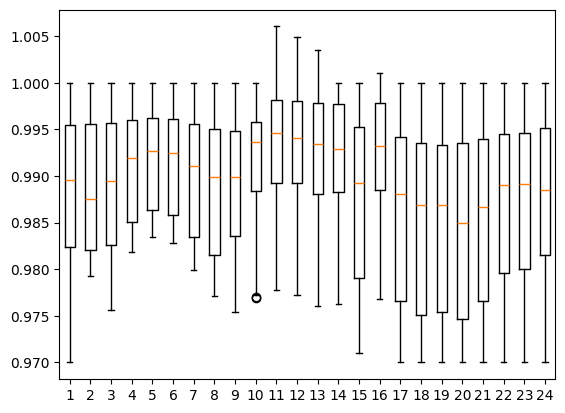

In [9]:
plt.boxplot(matpower_bus_res)

{'whiskers': [<matplotlib.lines.Line2D at 0x3554fe7d0>,
 'caps': [<matplotlib.lines.Line2D at 0x412b1a950>,
 'boxes': [<matplotlib.lines.Line2D at 0x3554ffbd0>,
 'medians': [<matplotlib.lines.Line2D at 0x412b1af90>,
 'fliers': [<matplotlib.lines.Line2D at 0x412b1a210>,
 'means': []}

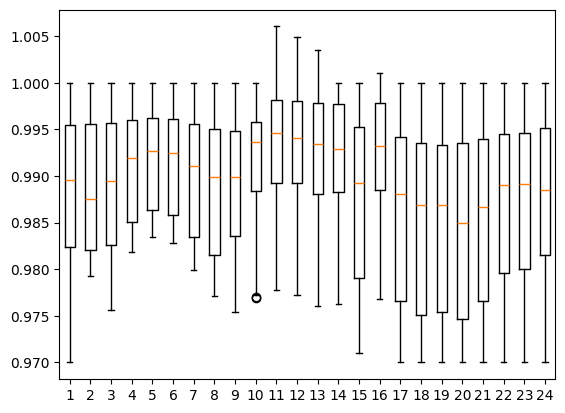

In [10]:
plt.boxplot(bus_res)